In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import math
from ngboost import NGBRegressor

## Génération des variables

In [36]:
n_samples=10000
µ = np.random.uniform(-5,5,n_samples)
sigma = np.random.uniform(0,10,n_samples)
Params = np.stack([µ,sigma]).T
y = np.array([np.random.normal(*param,size=1) for param in Params])

In [43]:
X = np.stack([µ,sigma]).T

X_train, X_test, y_train, y_test = train_test_split(X,y)
y_train = y_train.T[0]
y_test =y_test.T[0]

## Entraînement

In [44]:
def train_model(max_depth=3,n_estimators=500,ordinary_gradient=False,early_stopping_rounds=None) :
    tree = DecisionTreeRegressor(criterion='friedman_mse', max_depth=max_depth)

    if ordinary_gradient :
        model = NGBRegressor(Base=tree,n_estimators=n_estimators,natural_gradient=False)
    else :
        model = NGBRegressor(Base=tree,n_estimators=n_estimators)

    if early_stopping_rounds is not None :
        model.fit(X_train,y_train,
                  X_val=X_test,
                  Y_val=y_test,
                  early_stopping_rounds=early_stopping_rounds
                )
    else :
        model.fit(X_train,y_train,
                  X_val=X_test,
                  Y_val=y_test
                )
    
    return model

In [45]:
models_natural = []
iterations = 0
while True :
    print(f'Number of iterations : {iterations}')
    models_natural.append(train_model(n_estimators = iterations,early_stopping_rounds= 3))
    if len(models_natural) >= 2 :
        if len(models_natural[-1].base_models) == len(models_natural[-2].base_models) :
            models_natural.pop(-1)
            break
    iterations += 20

Number of iterations : 0
Number of iterations : 20
[iter 0] loss=3.2910 val_loss=3.2569 scale=2.0000 norm=9.9443
Number of iterations : 40
[iter 0] loss=3.2910 val_loss=3.2569 scale=2.0000 norm=9.9443
Number of iterations : 60
[iter 0] loss=3.2910 val_loss=3.2569 scale=2.0000 norm=9.9443
Number of iterations : 80
[iter 0] loss=3.2910 val_loss=3.2569 scale=2.0000 norm=9.9443
Number of iterations : 100
[iter 0] loss=3.2910 val_loss=3.2569 scale=2.0000 norm=9.9443
Number of iterations : 120
[iter 0] loss=3.2910 val_loss=3.2569 scale=2.0000 norm=9.9443
[iter 100] loss=2.9204 val_loss=2.9105 scale=2.0000 norm=8.2049
Number of iterations : 140
[iter 0] loss=3.2910 val_loss=3.2569 scale=2.0000 norm=9.9443
[iter 100] loss=2.9204 val_loss=2.9105 scale=2.0000 norm=8.2049
Number of iterations : 160
[iter 0] loss=3.2910 val_loss=3.2569 scale=2.0000 norm=9.9443
[iter 100] loss=2.9204 val_loss=2.9105 scale=2.0000 norm=8.2049
Number of iterations : 180
[iter 0] loss=3.2910 val_loss=3.2569 scale=2.000

In [46]:
models_ordinary = []
iterations = 0
while True :
    print(f'Number of iterations : {iterations}')
    models_ordinary.append(train_model(n_estimators = iterations,early_stopping_rounds= 3,ordinary_gradient=True))
    if len(models_ordinary) >= 2 :
        if len(models_ordinary[-1].base_models) == len(models_ordinary[-2].base_models) :
            models_ordinary.pop(-1)
            break
    if iterations >= 800 :
        break
    iterations += 20

Number of iterations : 0
Number of iterations : 20
[iter 0] loss=3.2910 val_loss=3.2606 scale=1.0000 norm=1.1014
Number of iterations : 40
[iter 0] loss=3.2910 val_loss=3.2606 scale=1.0000 norm=1.1014
Number of iterations : 60
[iter 0] loss=3.2910 val_loss=3.2606 scale=1.0000 norm=1.1014
Number of iterations : 80
[iter 0] loss=3.2910 val_loss=3.2606 scale=1.0000 norm=1.1014
Number of iterations : 100
[iter 0] loss=3.2910 val_loss=3.2606 scale=1.0000 norm=1.1014
Number of iterations : 120
[iter 0] loss=3.2910 val_loss=3.2606 scale=1.0000 norm=1.1014
[iter 100] loss=3.1121 val_loss=3.1020 scale=1.0000 norm=0.8787
Number of iterations : 140
[iter 0] loss=3.2910 val_loss=3.2606 scale=1.0000 norm=1.1014
[iter 100] loss=3.1121 val_loss=3.1020 scale=1.0000 norm=0.8787
Number of iterations : 160
[iter 0] loss=3.2910 val_loss=3.2606 scale=1.0000 norm=1.1014
[iter 100] loss=3.1121 val_loss=3.1020 scale=1.0000 norm=0.8787
Number of iterations : 180
[iter 0] loss=3.2910 val_loss=3.2606 scale=1.000

In [47]:
µ0, sigma0 = -3,3
objective = np.array([[µ0/(sigma0**2),-1/(2*(sigma0**2))]])


predictions_natural = []
for model in models_natural :
    predictions_natural.append(model.pred_dist(objective).params)
predictions_natural = np.array([np.stack([pred['loc'], pred['scale']]).T[0] for pred in predictions_natural])

predictions_ordinary = []
for model in models_ordinary :
    predictions_ordinary.append(model.pred_dist(objective).params)
predictions_ordinary = np.array([np.stack([pred['loc'], pred['scale']]).T[0] for pred in predictions_ordinary])

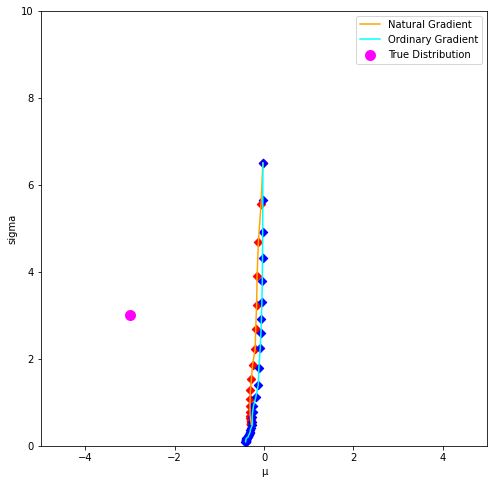

In [48]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(predictions_natural[:,0],predictions_natural[:,1],color='orange',label = 'Natural Gradient')
ax.scatter(predictions_natural[:,0],predictions_natural[:,1],color='red',marker='D')

ax.plot(predictions_ordinary[:,0],predictions_ordinary[:,1],color='cyan',label= 'Ordinary Gradient')
ax.scatter(predictions_ordinary[:,0],predictions_ordinary[:,1],color='blue',marker='D')

ax.scatter(µ0, sigma0, marker = 'o', color = 'magenta',linewidths=5,label='True Distribution')

ax.set_xlim([-5,5])
ax.set_ylim([0,10])
ax.set_xlabel('µ')
ax.set_ylabel('sigma')
ax.legend()
plt.show()

In [86]:
model_0 = models_ordinary[-1]
model_1 = models_natural[-1]

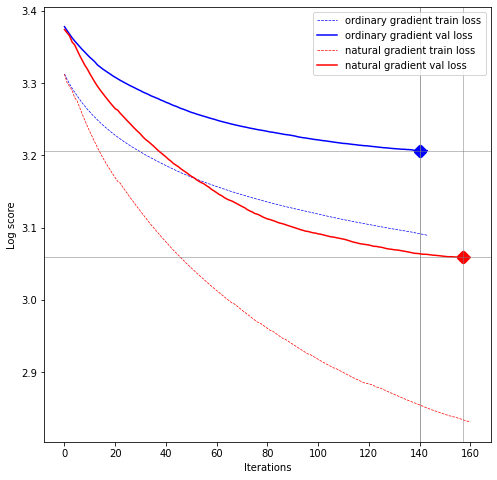

In [87]:
def plot_training(model_ordinary_gradient, model_natural_gradient) :
    val_0 = np.array(model_ordinary_gradient.evals_result['val']['LOGSCORE'])
    train_0 = np.array(model_ordinary_gradient.evals_result['train']['LOGSCORE'])
    val_1 = np.array(model_natural_gradient.evals_result['val']['LOGSCORE'])
    train_1 = np.array(model_natural_gradient.evals_result['train']['LOGSCORE'])
    fig, ax = plt.subplots(figsize = (8,8))
    ax.plot(train_0,'--',color='blue',linewidth=0.7,label='ordinary gradient train loss')
    ax.plot(val_0,color='blue',label='ordinary gradient val loss')
    ax.scatter(val_0.argmin(),val_0.min(),color='blue',marker='D',linewidths=5)
    ax.axvline(x=val_0.argmin(),color='grey',linewidth=0.5)
    ax.axhline(y=val_0.min(),color='grey',linewidth=0.5)
    ax.axvline(x=val_0.argmin(),color='grey',linewidth=0.5)
    ax.plot(train_1,'--',color='red',linewidth=0.7,label='natural gradient train loss')
    ax.plot(val_1,color='red',label='natural gradient val loss')
    ax.scatter(val_1.argmin(),val_1.min(),color='red',marker='D',linewidths=5)
    ax.axvline(x=val_1.argmin(),color='grey',linewidth=0.5)
    ax.axhline(y=val_1.min(),color='grey',linewidth=0.5)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Log score')
    ax.legend(loc='upper right')
    plt.show()

plot_training(model_0,model_1)